<a href="https://colab.research.google.com/github/natdebandi/hate_speech_ar/blob/main/4_model_comparison_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP final - reconocimiento de discursos discriminatorios en Twitter

## Comparacion de modelos binarios

**Natalia Dedandi**




In [1]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


In [2]:
!pip install datasets seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requir

In [3]:
import json
from openai import OpenAI
import os
from google.colab import userdata
#seteo la KEY
os.environ['OPENAI_API_KEY'] = userdata.get('openIA_key')




In [4]:
#creo el cliente OPENAI con mi usuario y proyecto
client = OpenAI(
  organization='org-1uHjwiaB3OlPzoxfVzhqOSzs',
  project='proj_2fII7izwVGgYaERNNKhhMx4l',
)

Traigo el data set y quiero aplicarle el clasificador al conjunto de TEST y de eval

In [5]:
from datasets import load_dataset
import pandas as pd

ds1 = load_dataset("piuba-bigdata/contextualized_hate_speech")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/36420 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11343 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/9106 [00:00<?, ? examples/s]

In [6]:
ds1

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 36420
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 11343
    })
    dev: Dataset({
        features: ['id', 'title', 'text', 'context_tweet', 'HATEFUL', 'body', 'CALLS', 'WOMEN', 'LGBTI', 'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL'],
        num_rows: 9106
    })
})

In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
from transformers import pipeline

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(labels, prediction):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(labels, predictions)
    metrics['Precision'] = precision_score(labels, predictions)
    metrics['Recall'] = recall_score(labels, predictions)
    metrics['f1'] = f1_score(labels, predictions)
    metrics['AUC'] = roc_auc_score(labels, predictions)

    return(metrics)

Aplico el clasificador binario con fintuning basado en BETO al conjunto de test

In [10]:


test_texts = ds1['test']['text']
tw_list = list(test_texts)


In [11]:
specific_model = pipeline(model="natdebandi/beto_hate_speech_ar_bin", device=0)

outputs=specific_model(tw_list)

config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/735k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [21]:
outputs[10]

{'label': 'LABEL_0', 'score': 0.9998283386230469}

In [28]:
df_beto = pd.DataFrame(outputs)



In [29]:
df_beto['HATEFUL_pred'] = df_beto['label'].apply(lambda x: 0 if x == 'LABEL_0' else 1)

In [31]:
df_beto[20:30]

,label,score,HATEFUL_pred
20,LABEL_0,0.995678,0
21,LABEL_0,0.999597,0
22,LABEL_0,0.998200,0
23,LABEL_0,0.987661,0
24,LABEL_1,0.999053,1
25,LABEL_0,0.999407,0
26,LABEL_0,0.996082,0
27,LABEL_0,0.999770,0
28,LABEL_0,0.999746,0
29,LABEL_0,0.999678,0


In [33]:
df_test = pd.DataFrame(ds1['test'])[['id','text','HATEFUL']]


In [34]:
df_test[1:10]

,id,text,HATEFUL
1,397704,@usuario Faltó que se enganchó al hijo de sofo...,1
2,397705,"@usuario y bue, que le vaya a llorar a Cristin...",0
3,397706,@usuario @usuario Jodete. Macri te hizo conoce...,0
4,397707,"@usuario Que se joda, es su gobierno el que el...",0
5,397708,"@usuario Jajaajajajaaja que lástima!!! Anda, b...",0
6,397709,@usuario Que se joda,0
7,397710,@usuario SEGUI VOTANDO AL PERONISMO PELOTUDA,0
8,397711,@usuario Paaaaaaaaaaaaabreeeee!_shoro😭😭🤧,0
9,397712,@usuario TUGO,0


In [35]:
# prompt: merge df_test with df_beto

df_test_beto = pd.merge(df_test, df_beto, left_index=True, right_index=True)


In [37]:
df_test_beto[20:30]

,id,text,HATEFUL,label,score,HATEFUL_pred
20,397723,@usuario Votó eso.,0,LABEL_0,0.995678,0
21,397724,"@usuario Para lo poco que hacía,",0,LABEL_0,0.999597,0
22,397725,@usuario Estashi!!!,0,LABEL_0,0.998200,0
23,397726,@usuario @usuario El conchero...después que vo...,0,LABEL_0,0.987661,0
24,397727,@usuario Negra cabeza,1,LABEL_1,0.999053,1
25,397728,@usuario 🤣🤣🤣a comer polenta genia del voto,0,LABEL_0,0.999407,0
26,397729,@usuario No siento pena \nFuiste Voto K ?\nBan...,0,LABEL_0,0.996082,0
27,397730,@usuario Otra chorra K,0,LABEL_0,0.999770,0
28,397731,@usuario Otro logro más de @usuario,0,LABEL_0,0.999746,0
29,397732,@usuario Pero vota kirchnerismo,0,LABEL_0,0.999678,0


<ipython-input-38-795cedd03820>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_test_beto, x='HATEFUL', y='HATEFUL_pred', inner='stick', palette='Dark2')


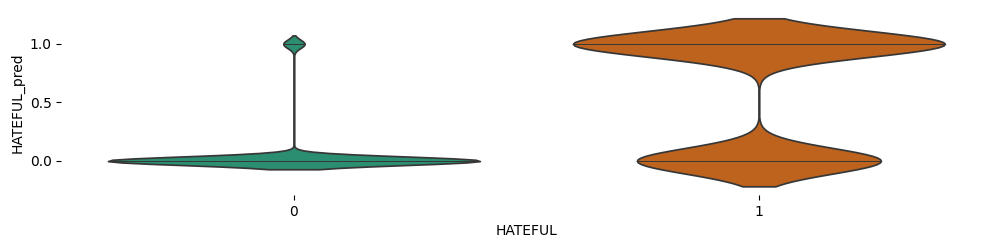

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_test_beto['HATEFUL_pred'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_test_beto, x='HATEFUL', y='HATEFUL_pred', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)